In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
%matplotlib inline

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (18724, 28, 28), (18724,))


In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 784), (200000, 10))
('Validation set', (10000, 784), (10000, 10))
('Test set', (18724, 784), (18724, 10))


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Problem 1: Baseline for logistic regression

In [72]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [73]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 19.6592
Minibatch accuracy: 5.5%
Validation accuracy: 8.2%
Minibatch loss at step 500 : 1.56872
Minibatch accuracy: 73.4%
Validation accuracy: 75.5%
Minibatch loss at step 1000 : 1.39899
Minibatch accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 1500 : 1.10509
Minibatch accuracy: 76.6%
Validation accuracy: 77.0%
Minibatch loss at step 2000 : 0.902614
Minibatch accuracy: 84.4%
Validation accuracy: 77.5%
Minibatch loss at step 2500 : 1.09693
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 3000 : 1.19934
Minibatch accuracy: 73.4%
Validation accuracy: 78.0%
Test accuracy: 85.9%


# Adding regularizition for logistic regression

In [113]:
batch_size = 128
lam = 5e-4
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+ lam*tf.nn.l2_loss(weights)+lam*tf.nn.l2_loss(biases))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [114]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 20.9466
Minibatch accuracy: 7.0%
Validation accuracy: 10.1%
Minibatch loss at step 500 : 2.61517
Minibatch accuracy: 70.3%
Validation accuracy: 76.0%
Minibatch loss at step 1000 : 2.01302
Minibatch accuracy: 74.2%
Validation accuracy: 78.1%
Minibatch loss at step 1500 : 1.31996
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 2000 : 1.11361
Minibatch accuracy: 82.0%
Validation accuracy: 79.6%
Minibatch loss at step 2500 : 1.08071
Minibatch accuracy: 82.0%
Validation accuracy: 79.6%
Minibatch loss at step 3000 : 0.986267
Minibatch accuracy: 78.1%
Validation accuracy: 80.3%
Test accuracy: 87.5%


# Baseline for 1-layer NN

In [115]:
batch_size = 128
node = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, node]))
  biases = tf.Variable(tf.zeros([node]))
  
 #### add a hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([node,num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits_train = tf.matmul(tf_train_dataset, weights) + biases
  sigmoid_train = tf.nn.relu(logits_train)
  logits_train1 = tf.matmul(sigmoid_train, weights1) + biases1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train1, tf_train_labels))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train1)
  logit_val=tf.matmul(tf_valid_dataset, weights) + biases
  sigmoid_val = tf.nn.relu(logit_val)
  logits_val1 = tf.matmul(sigmoid_val, weights1) + biases1
  valid_prediction = tf.nn.softmax(logits_val1)
  logit_test=tf.matmul(tf_test_dataset, weights) + biases
  sigmoid_test = tf.nn.relu(logit_test)
  logits_test1 = tf.matmul(sigmoid_test, weights1) + biases1
  test_prediction = tf.nn.softmax(logits_test1)

In [116]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 361.984
Minibatch accuracy: 7.8%
Validation accuracy: 30.6%
Minibatch loss at step 500 : 42.0269
Minibatch accuracy: 73.4%
Validation accuracy: 79.2%
Minibatch loss at step 1000 : 9.25481
Minibatch accuracy: 78.9%
Validation accuracy: 80.3%
Minibatch loss at step 1500 : 11.3963
Minibatch accuracy: 77.3%
Validation accuracy: 79.0%
Minibatch loss at step 2000 : 6.16731
Minibatch accuracy: 84.4%
Validation accuracy: 81.3%
Minibatch loss at step 2500 : 7.86795
Minibatch accuracy: 77.3%
Validation accuracy: 81.5%
Minibatch loss at step 3000 : 1.98448
Minibatch accuracy: 79.7%
Validation accuracy: 82.5%
Test accuracy: 89.5%


# Add regularization for NN

In [181]:
batch_size = 128
node = 1024
lamba = 5e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, node]))
  biases = tf.Variable(tf.zeros([node]))
  
 #### add a hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([node,num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits_train = tf.matmul(tf_train_dataset, weights) + biases
  sigmoid_train = tf.nn.relu(logits_train)
  logits_train1 = tf.matmul(sigmoid_train, weights1) + biases1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train1, tf_train_labels)+ lamba*tf.nn.l2_loss(weights)+lamba*tf.nn.l2_loss(biases)+ lamba*tf.nn.l2_loss(weights1)+lamba*tf.nn.l2_loss(biases1))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train1)
  logit_val=tf.matmul(tf_valid_dataset, weights) + biases
  sigmoid_val = tf.nn.relu(logit_val)
  logits_val1 = tf.matmul(sigmoid_val, weights1) + biases1
  valid_prediction = tf.nn.softmax(logits_val1)
  logit_test=tf.matmul(tf_test_dataset, weights) + biases
  sigmoid_test = tf.nn.relu(logit_test)
  logits_test1 = tf.matmul(sigmoid_test, weights1) + biases1
  test_prediction = tf.nn.softmax(logits_test1)

In [220]:
num_steps = 501
train_accuracy=[]
validation_accuracy=[]
test_accuracy= []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      train_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
      if(step%500 ==0):
        print "Minibatch loss at step", step, ":", l
        print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
        print "Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels)
        print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)


Initialized
Minibatch loss at step 0 : 1882.64
Minibatch accuracy: 17.2%
Validation accuracy: 20.1%
Test accuracy: 21.9%
Minibatch loss at step 500 : 965.998
Minibatch accuracy: 74.2%
Validation accuracy: 80.6%
Test accuracy: 87.5%


(3, 10)


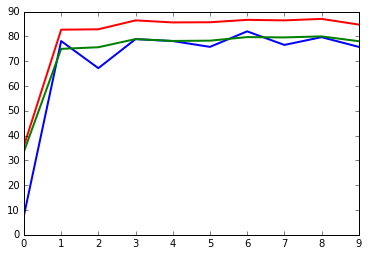

In [219]:
x = np.arange(0,10,1)
y = np.vstack([train_accuracy,validation_accuracy,test_accuracy])
print y.shape
plt.plot(x, y.T[x], linewidth=2)
plt.show()

# Problem 2 : Looking down to overfitting

In [164]:
batch_size = 50
node = 1024
lamba = 5e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, node]))
  biases = tf.Variable(tf.zeros([node]))
  
 #### add a hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([node,num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits_train = tf.matmul(tf_train_dataset, weights) + biases
  sigmoid_train = tf.nn.relu(logits_train)
  logits_train1 = tf.matmul(sigmoid_train, weights1) + biases1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train1, tf_train_labels)+ lamba*tf.nn.l2_loss(weights)+lamba*tf.nn.l2_loss(biases)+ lamba*tf.nn.l2_loss(weights1)+lamba*tf.nn.l2_loss(biases1))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train1)
  logit_val=tf.matmul(tf_valid_dataset, weights) + biases
  sigmoid_val = tf.nn.relu(logit_val)
  logits_val1 = tf.matmul(sigmoid_val, weights1) + biases1
  valid_prediction = tf.nn.softmax(logits_val1)
  logit_test=tf.matmul(tf_test_dataset, weights) + biases
  sigmoid_test = tf.nn.relu(logit_test)
  logits_test1 = tf.matmul(sigmoid_test, weights1) + biases1
  test_prediction = tf.nn.softmax(logits_test1)

In [165]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 1959.95
Minibatch accuracy: 4.0%
Validation accuracy: 37.2%
Minibatch loss at step 500 : 129.86
Minibatch accuracy: 80.0%
Validation accuracy: 78.6%
Minibatch loss at step 1000 : 11.0844
Minibatch accuracy: 82.0%
Validation accuracy: 83.3%
Minibatch loss at step 1500 : 1.59171
Minibatch accuracy: 80.0%
Validation accuracy: 82.2%
Minibatch loss at step 2000 : 0.644427
Minibatch accuracy: 88.0%
Validation accuracy: 82.2%
Minibatch loss at step 2500 : 0.650042
Minibatch accuracy: 84.0%
Validation accuracy: 83.4%
Minibatch loss at step 3000 : 0.959194
Minibatch accuracy: 74.0%
Validation accuracy: 82.1%
Test accuracy: 89.3%


# Testing on the method of dropout

In [47]:
batch_size = 1280
node = 1024
lamba = 5e-3
SEED = 66478

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, node]))
  biases = tf.Variable(tf.zeros([node]))
  
 #### add a hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([node,num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits_train = tf.matmul(tf_train_dataset, weights) + biases
  sigmoid_train = tf.nn.relu(logits_train)
  dropout = tf.nn.dropout(sigmoid_train,0.5,seed=SEED)
  logits_train1 = tf.matmul(dropout, weights1) + biases1
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train1, tf_train_labels)+ lamba*tf.nn.l2_loss(weights)+lamba*tf.nn.l2_loss(biases)+ lamba*tf.nn.l2_loss(weights1)+lamba*tf.nn.l2_loss(biases1))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train1)
  logit_val=tf.matmul(tf_valid_dataset, weights) + biases
  sigmoid_val = tf.nn.relu(logit_val)
  logits_val1 = tf.matmul(sigmoid_val, weights1) + biases1
  valid_prediction = tf.nn.softmax(logits_val1)
  logit_test=tf.matmul(tf_test_dataset, weights) + biases
  sigmoid_test = tf.nn.relu(logit_test)
  logits_test1 = tf.matmul(sigmoid_test, weights1) + biases1
  test_prediction = tf.nn.softmax(logits_test1)

In [49]:
num_steps = 1501

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 2039.25
Minibatch accuracy: 11.7%
Validation accuracy: 35.6%
Minibatch loss at step 500 : 126.314
Minibatch accuracy: 79.9%
Validation accuracy: 84.2%
Minibatch loss at step 1000 : 10.7984
Minibatch accuracy: 85.8%
Validation accuracy: 86.1%
Minibatch loss at step 1500 : 1.39295
Minibatch accuracy: 87.3%
Validation accuracy: 85.7%
Test accuracy: 92.1%


# Improve model make the accuray as higher as possible(+regulariztion+learning_rate_decay+dropout)

In [86]:
batch_size = 128
node_hidden1 = 1024
node_hidden2 = 500
node_hidden3 = 300
node_hidden4 = 50
lamba = 5e-3
SEED = 66478

# 3_layer_NN
def NN(dataset, weights, weights1, weights2, weights3,weights4, biases,biases1,biases2,biases3,biases4):
  logits_train = tf.matmul(dataset, weights) + biases
  sigmoid_train = tf.nn.tanh(logits_train)
  #dropout = tf.nn.dropout(sigmoid_train,0.5,seed=SEED)
  logits_train1 = tf.matmul(sigmoid_train, weights1) + biases1
  sigmoid_train1 = tf.nn.tanh(logits_train1)
  #dropout1 = tf.nn.dropout(sigmoid_train1,0.5,seed=SEED)
  logits_train2 = tf.matmul(sigmoid_train1, weights2) + biases2
  sigmoid_train2 = tf.nn.tanh(logits_train2)
  #dropout2 = tf.nn.dropout(sigmoid_train2,0.5,seed=SEED)
  logits_train3 = tf.matmul(sigmoid_train2, weights3) + biases3
  sigmoid_train3 = tf.nn.tanh(logits_train3)
  logits_train4 = tf.matmul(sigmoid_train3, weights4) + biases4
  return logits_train4

# def NN_non_train(dataset, weights, weights1, weights2,weights3, weights4,biases,biases1,biases2,biases3,biases4):
#   logits_train = tf.matmul(dataset, weights) + biases
#   sigmoid_train = tf.nn.tanh(logits_train)
#   logits_train1 = tf.matmul(sigmoid_train, weights1) + biases1
#   sigmoid_train1 = tf.nn.tanh(logits_train1)
#   logits_train2 = tf.matmul(sigmoid_train1, weights2) + biases2
#   sigmoid_train2 = tf.nn.tanh(logits_train2)
#   logits_train3 = tf.matmul(sigmoid_train2, weights3) + biases3
#   sigmoid_train3 = tf.nn.tanh(logits_train3)
#   logits_train4 = tf.matmul(sigmoid_train3, weights4) + biases4
#   return logits_train4
    
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, node_hidden1]))
  biases = tf.Variable(tf.zeros([node_hidden1]))
  
 #### add 1st hidden layer
  weights1 = tf.Variable(
    tf.truncated_normal([node_hidden1,node_hidden2]))
  biases1 = tf.Variable(tf.zeros([node_hidden2]))  
    
 #### add 2nd hidden layer
  weights2 = tf.Variable(
    tf.truncated_normal([node_hidden2,node_hidden3]))
  biases2 = tf.Variable(tf.zeros([node_hidden3]))  

    
 #### add 3rd hidden layer
  weights3 = tf.Variable(
    tf.truncated_normal([node_hidden3,node_hidden4]))
  biases3 = tf.Variable(tf.zeros([node_hidden4]))  

#### add 4th hidden layer
  weights4 = tf.Variable(
    tf.truncated_normal([node_hidden4,num_labels]))
  biases4 = tf.Variable(tf.zeros([num_labels]))
    
 #### Rate decay
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.1, global_step,100000,0.95,staircase=True)

  # Training computation.
  logits_train4 = NN(tf_train_dataset,weights, weights1, weights2,weights3,weights4,biases,biases1,biases2,biases3,biases4)
  L2 = lamba*tf.nn.l2_loss(weights)+lamba*tf.nn.l2_loss(biases)+ lamba*tf.nn.l2_loss(weights1)+lamba*tf.nn.l2_loss(biases1)+ lamba*tf.nn.l2_loss(weights2)+lamba*tf.nn.l2_loss(biases2)+ lamba*tf.nn.l2_loss(weights3)+lamba*tf.nn.l2_loss(biases3)+ lamba*tf.nn.l2_loss(weights4)+lamba*tf.nn.l2_loss(biases4)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train4, tf_train_labels)+L2)

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_train4)
  logits_val = NN(tf_valid_dataset, weights, weights1, weights2,weights3,weights4,biases,biases1,biases2,biases3,biases4)
  valid_prediction = tf.nn.softmax(logits_val)
  logits_test = NN(tf_test_dataset, weights, weights1, weights2,weights3,weights4,biases,biases1,biases2,biases3,biases4)
  test_prediction = tf.nn.softmax(logits_test)

In [87]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 2868.2
Minibatch accuracy: 10.9%
Validation accuracy: 10.9%
Minibatch loss at step 500 : 1742.81
Minibatch accuracy: 62.5%
Validation accuracy: 58.5%
Minibatch loss at step 1000 : 1057.64
Minibatch accuracy: 68.8%
Validation accuracy: 68.6%
Minibatch loss at step 1500 : 641.844
Minibatch accuracy: 73.4%
Validation accuracy: 73.3%
Minibatch loss at step 2000 : 389.51
Minibatch accuracy: 78.1%
Validation accuracy: 76.4%
Minibatch loss at step 2500 : 236.57
Minibatch accuracy: 78.9%
Validation accuracy: 79.0%
Minibatch loss at step 3000 : 143.82
Minibatch accuracy: 77.3%
Validation accuracy: 80.7%
Minibatch loss at step 3500 : 87.4859
Minibatch accuracy: 81.2%
Validation accuracy: 82.4%
Minibatch loss at step 4000 : 53.0652
Minibatch accuracy: 89.1%
Validation accuracy: 83.6%
Minibatch loss at step 4500 : 32.3889
Minibatch accuracy: 85.2%
Validation accuracy: 84.7%
Minibatch loss at step 5000 : 19.8534
Minibatch accuracy: 85.2%
Validation accuracy: 8